In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from sklearn.svm import SVC
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Generate dataset

In [2]:
y = np.random.randint(0,3,150)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 49
1 50
2 51


In [3]:
x = np.zeros((150,2))
# x1 = np.zeros((500,2))

In [4]:
# x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
# x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
# x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))
# x[idx[3],:] = np.random.normal(loc = 3)


In [5]:
x[idx[0]] = np.random.uniform(low =[-1,1],high =[-1.5,2],size= (sum(idx[0]),2))
x[idx[2]] = np.random.uniform(low =[-1,3],high =[-1.5,4],size= (sum(idx[2]),2))
x[idx[1]] = np.random.uniform(low =[3,2],high =[3.5,3],size= (sum(idx[1]),2))


In [6]:
# x,y = np.concatenate((x,x1),axis=0),np.concatenate((y,y),axis=0)
x.shape,y.shape

((150, 2), (150,))

# Visualise Data Distribution

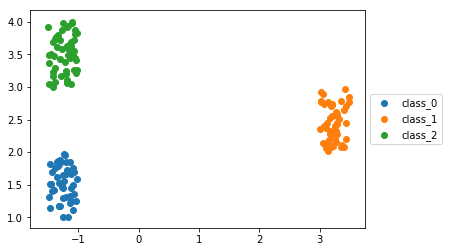

In [7]:
for i in range(3):
    #y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
foreground_classes = {'class_0','class_1'}

background_classes = {'class_2'}

In [9]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,3)
bg_class = 2
a = []
for i in range(3):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
#print(a.shape)

print(fg_class , fg_idx)

foreground 0 present at 0
background 2 present at 1
background 2 present at 2
0 0


In [10]:
a

array([[-1.09555686,  1.10855101],
       [-1.02383633,  3.26038923],
       [-1.45108399,  3.50976195]])

In [11]:
desired_num = 1000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,3)
    bg_class = 2
    a = []
    for i in range(3):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(6,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [12]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
print(mosaic_list)

[[-1.23269373  1.96555056 -1.28351827  3.17146055 -1.18324947  3.63458394]
 [ 3.40826722  2.64091541 -1.11814672  3.04001368 -1.03887861  3.21514203]
 [-1.14165425  3.45053504  3.10098585  2.07029234 -1.16993971  3.48318298]
 ..., 
 [-1.38222226  3.7407212  -1.1386644   1.84802751 -1.06915316  3.26396124]
 [-1.19887374  3.23798519 -1.18759147  3.1047543   3.28060437  2.42640035]
 [-1.27724826  3.57425977 -1.32241067  1.1793063  -1.24865326  3.97929504]]


In [13]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(1000,)
(1000,)


In [14]:
mosaic_list[:,0:2].shape

(1000, 2)

In [15]:
class MosaicDataset(Dataset):
    """MosaicDataset dataset."""
    
    
    def __init__(self, mosaic_list, mosaic_label, fore_idx):
        """
          Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mosaic = mosaic_list
        self.label = mosaic_label
        self.fore_idx = fore_idx

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=False)

In [16]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(2,1)
    def forward(self,z):
        x = torch.zeros([batch,3],dtype=torch.float64)
        y = torch.zeros([batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(3):
            x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        #print(x.shape)
        x1 = x[:,0]
        for i in range(3):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return y , x 

    
    def helper(self,x):
        x = self.linear1(x)
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)
        
        return x

    

In [17]:
where = Wherenet().double()


In [18]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,2)
#         self.linear2 = nn.Linear(8,16)
#         self.linear3 = nn.Linear(16,3)
    def forward(self,x):
        x = self.linear1(x)
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
        return x

In [19]:
what =Whatnet().double()


In [20]:
X = []
Y = []
for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
        
    X.append(inputs.numpy())
    Y.append(labels.numpy())
X = np.concatenate(X,axis=0)
Y  = np.concatenate(Y,axis=0)

In [21]:
clf = SVC(C = 10000,kernel= "linear",gamma='auto')

In [22]:
clf.fit(X,Y)
print(clf.score(X,Y))

1.0


In [23]:
def disp_plot(data,avg_data,true_label,pred_label,alpha,true_idx):
    plt.figure(figsize=(6,6))
    data = data.numpy()
    alpha = alpha.detach().numpy()
    avg_data = avg_data.detach().numpy()
 
    x = data[:,0:2]
    y = data[:,2:4]
    z = data[:,4:6]
    colors = ['b','g','r','c','m','y','k','teal','indigo','peru']
    
    #print(data[0],avg_data[0])
    for i in range(0,10):
        plt.plot([x[i,0],y[i,0]],[x[i,1],y[i,1]],color= colors[i])#,marker ='o-')
        plt.plot([z[i,0],y[i,0]],[z[i,1],y[i,1]],color= colors[i])#,marker ='o-')
        plt.plot([x[i,0],z[i,0]],[x[i,1],z[i,1]],color= colors[i])#,marker ='o-')
#         print("dssda",avg_data[i,0],avg_data[i,1])
#         print("aaaaa",x,y,z)
        plt.plot(avg_data[i,0], avg_data[i,1],marker="x", markersize=12, color= colors[i])
        


[1,     4] loss: 1.211
[1,    4] accuracy: 0.033
[2,     4] loss: 0.824
[2,    4] accuracy: 0.189
[3,     4] loss: 0.540
[3,    4] accuracy: 0.952
[4,     4] loss: 0.378
[4,    4] accuracy: 1.000
[5,     4] loss: 0.249
[5,    4] accuracy: 1.000
[6,     4] loss: 0.145
[6,    4] accuracy: 1.000
[7,     4] loss: 0.082
[7,    4] accuracy: 1.000
[8,     4] loss: 0.050
[8,    4] accuracy: 1.000
[9,     4] loss: 0.033
[9,    4] accuracy: 1.000
[10,     4] loss: 0.024
[10,    4] accuracy: 1.000
[11,     4] loss: 0.019
[11,    4] accuracy: 1.000
[12,     4] loss: 0.016
[12,    4] accuracy: 1.000
[13,     4] loss: 0.013
[13,    4] accuracy: 1.000
[14,     4] loss: 0.012
[14,    4] accuracy: 1.000
[15,     4] loss: 0.011
[15,    4] accuracy: 1.000
[16,     4] loss: 0.010
[16,    4] accuracy: 1.000
[17,     4] loss: 0.009
[17,    4] accuracy: 1.000
[18,     4] loss: 0.009
[18,    4] accuracy: 1.000
[19,     4] loss: 0.008
[19,    4] accuracy: 1.000
[20,     4] loss: 0.008
[20,    4] accuracy: 1.00

C:\Users\lenovo\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[21,     4] loss: 0.008
[21,    4] accuracy: 1.000
[22,     4] loss: 0.007
[22,    4] accuracy: 1.000
[23,     4] loss: 0.007
[23,    4] accuracy: 1.000
[24,     4] loss: 0.007
[24,    4] accuracy: 1.000
[25,     4] loss: 0.007
[25,    4] accuracy: 1.000
[26,     4] loss: 0.007
[26,    4] accuracy: 1.000
[27,     4] loss: 0.006
[27,    4] accuracy: 1.000
[28,     4] loss: 0.006
[28,    4] accuracy: 1.000
[29,     4] loss: 0.006
[29,    4] accuracy: 1.000
[30,     4] loss: 0.006
[30,    4] accuracy: 1.000
[31,     4] loss: 0.006
[31,    4] accuracy: 1.000
[32,     4] loss: 0.006
[32,    4] accuracy: 1.000
[33,     4] loss: 0.005
[33,    4] accuracy: 1.000
[34,     4] loss: 0.005
[34,    4] accuracy: 1.000
[35,     4] loss: 0.005
[35,    4] accuracy: 1.000
[36,     4] loss: 0.005
[36,    4] accuracy: 1.000
[37,     4] loss: 0.005
[37,    4] accuracy: 1.000
[38,     4] loss: 0.005
[38,    4] accuracy: 1.000
[39,     4] loss: 0.005
[39,    4] accuracy: 1.000
[40,     4] loss: 0.005
[40,   

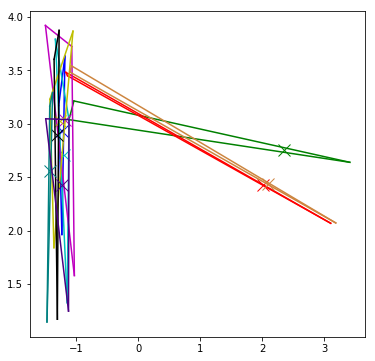

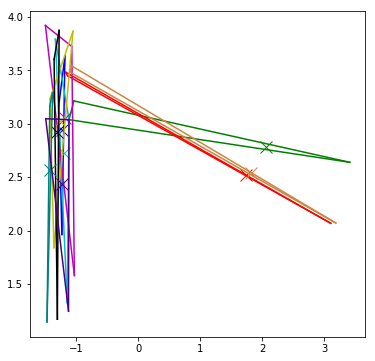

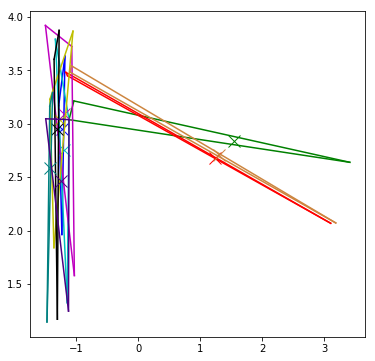

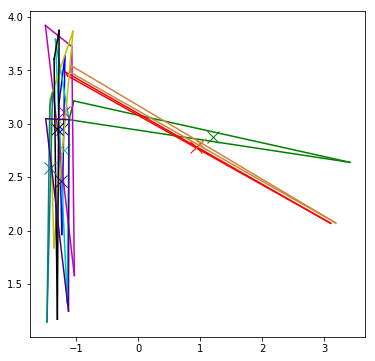

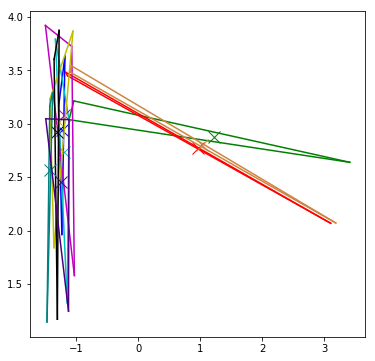

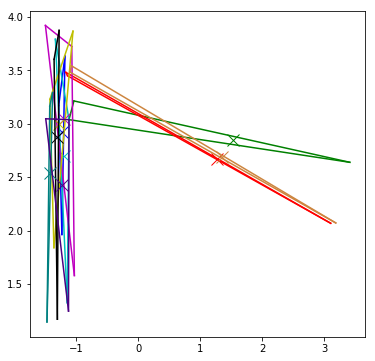

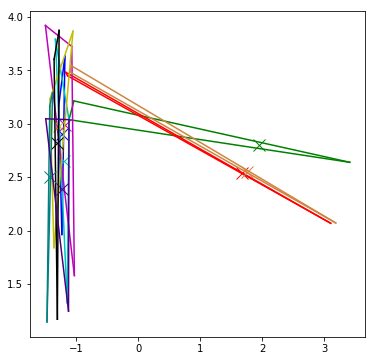

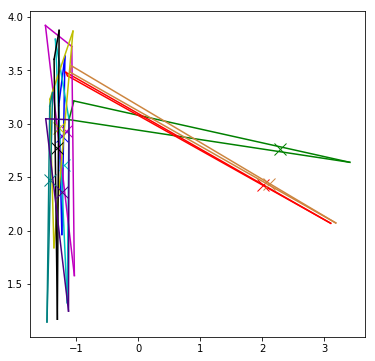

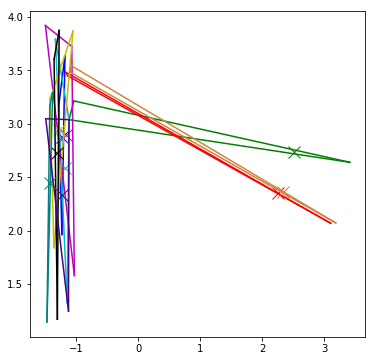

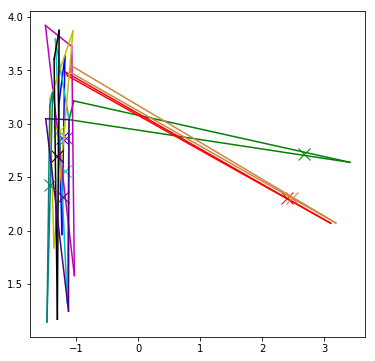

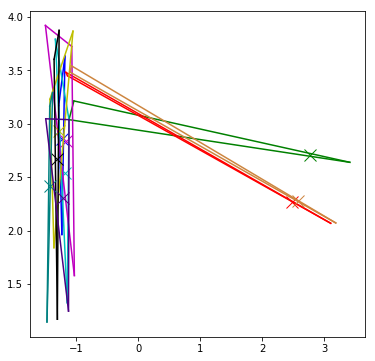

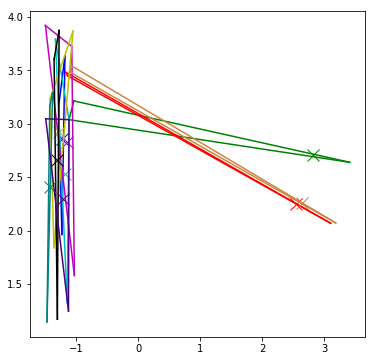

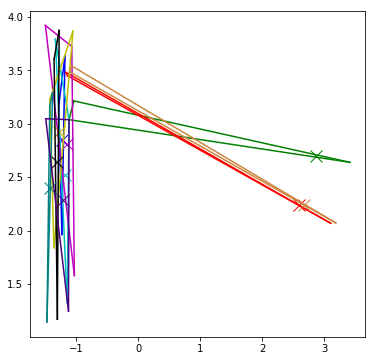

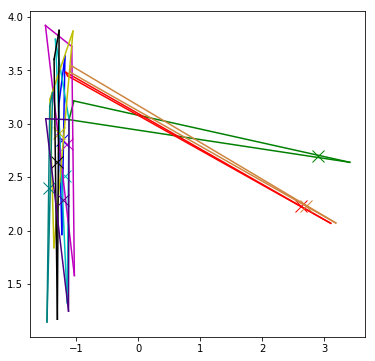

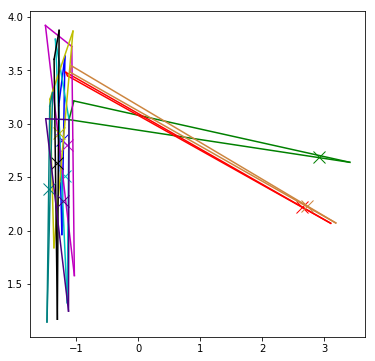

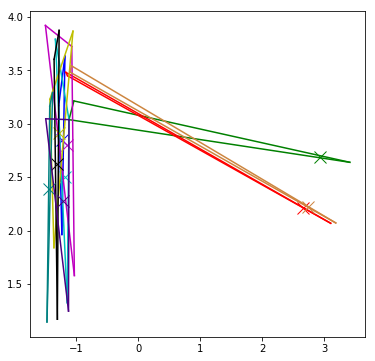

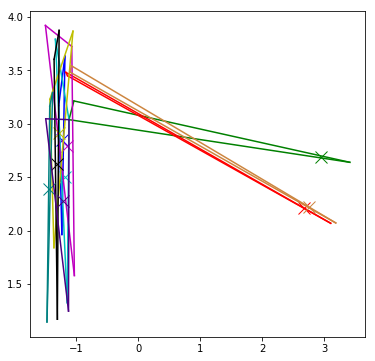

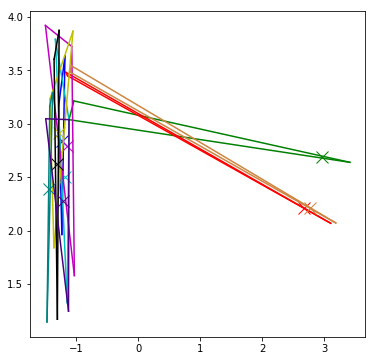

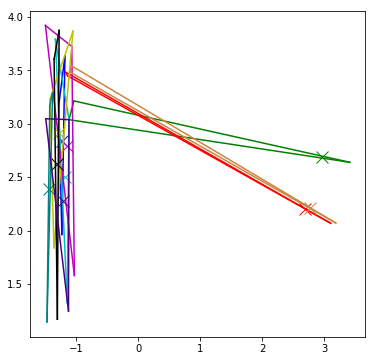

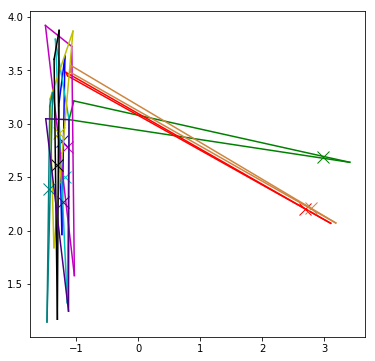

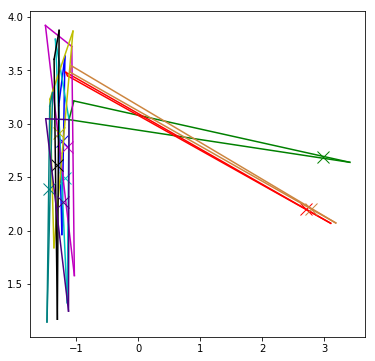

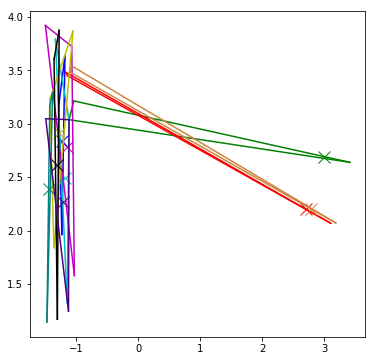

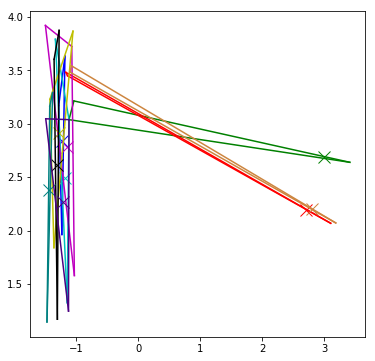

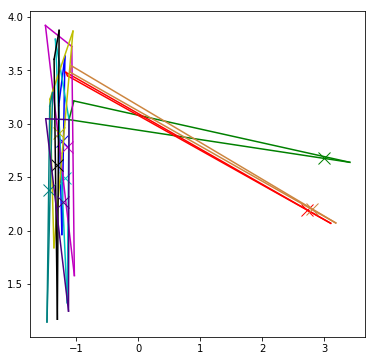

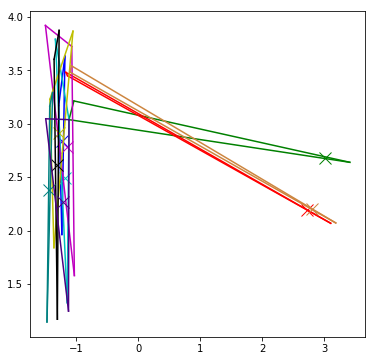

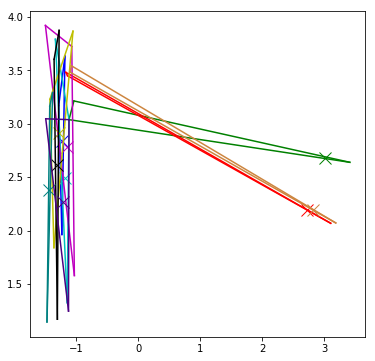

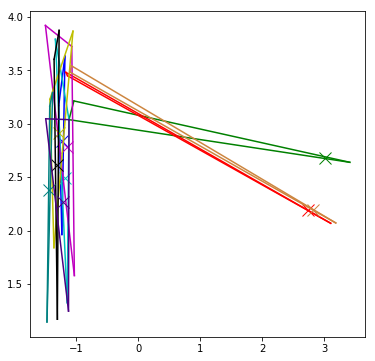

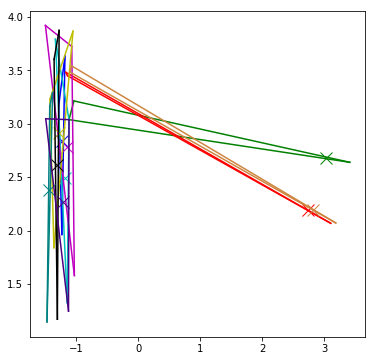

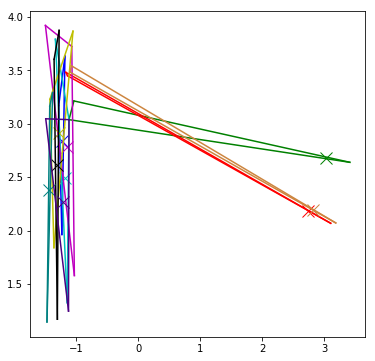

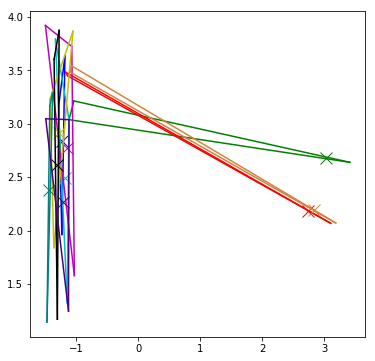

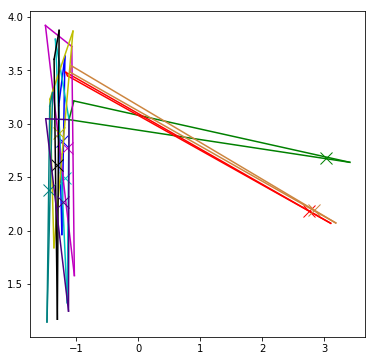

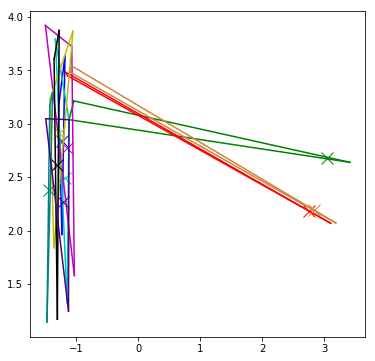

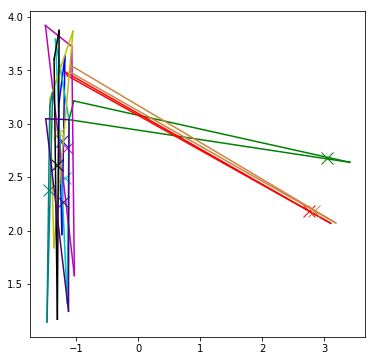

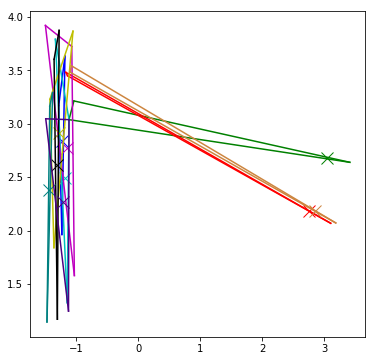

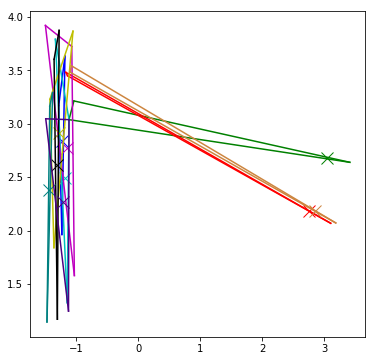

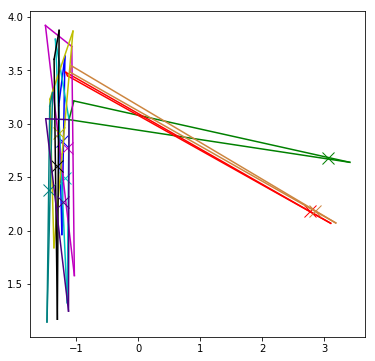

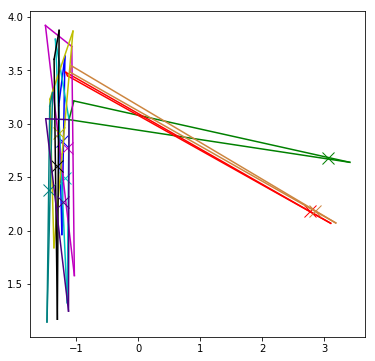

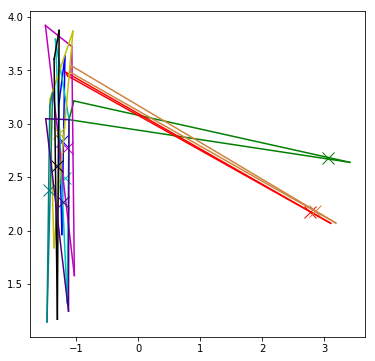

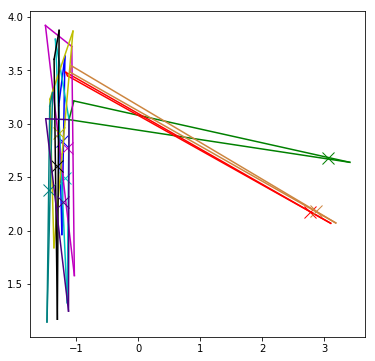

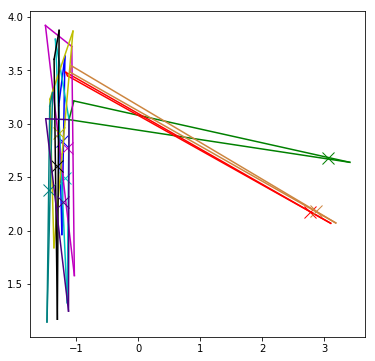

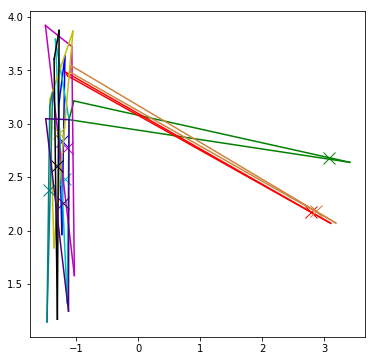

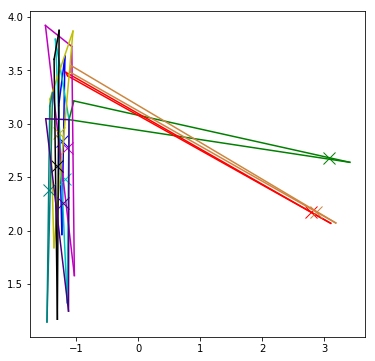

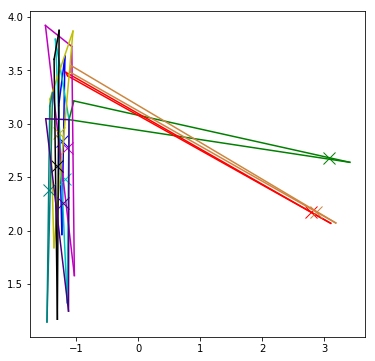

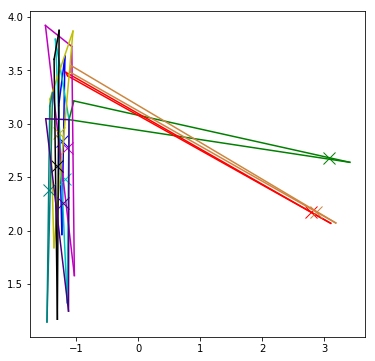

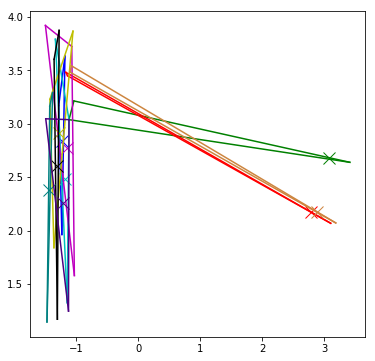

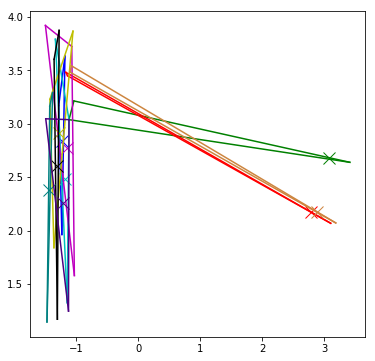

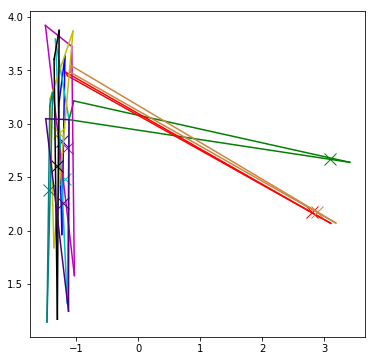

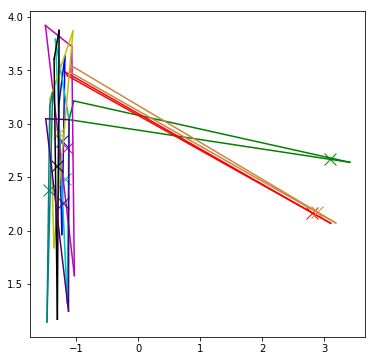

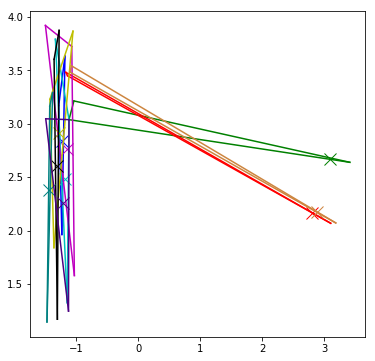

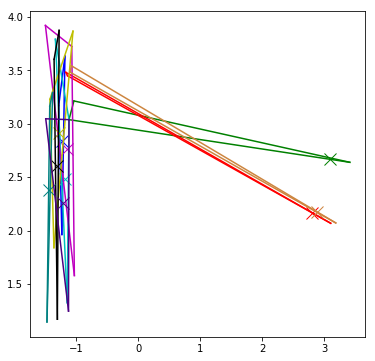

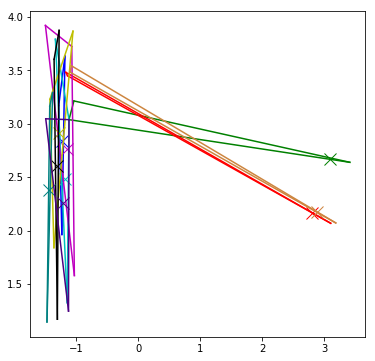

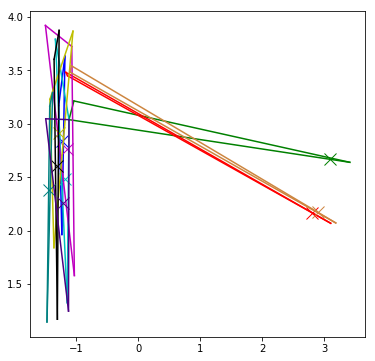

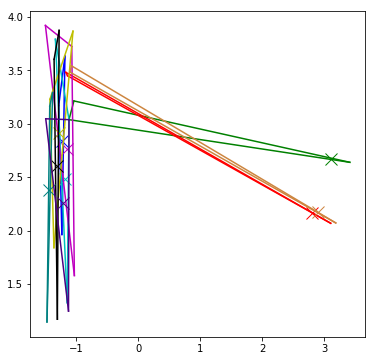

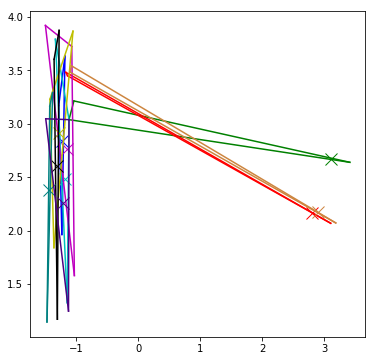

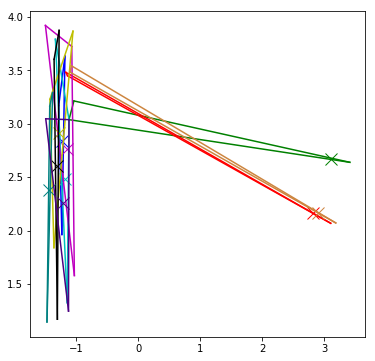

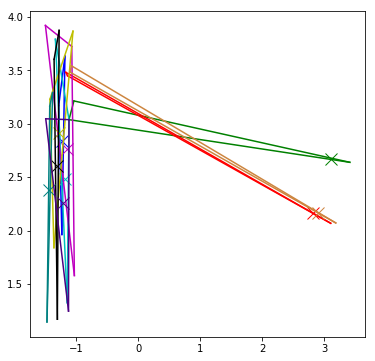

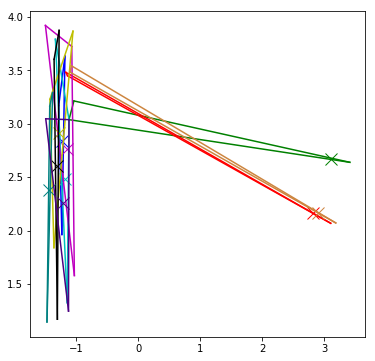

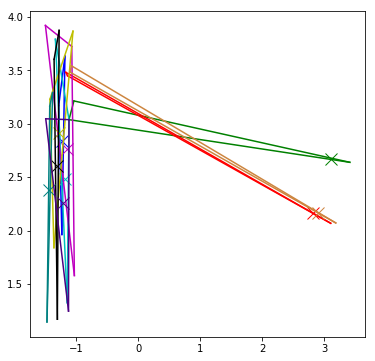

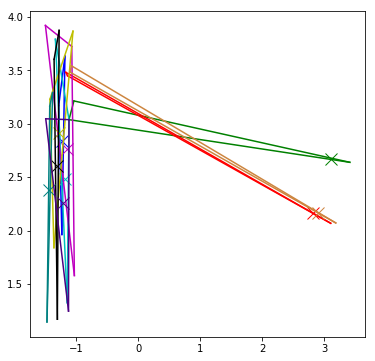

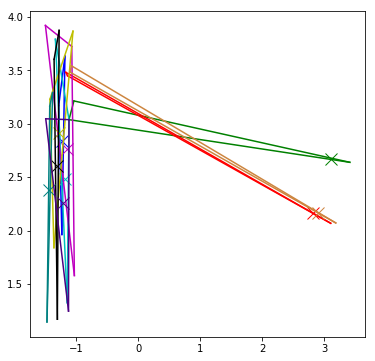

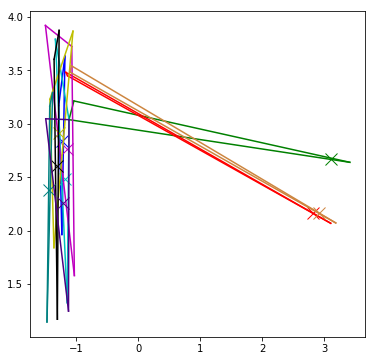

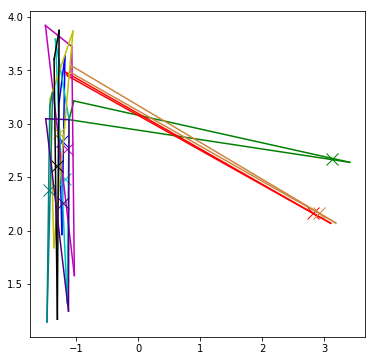

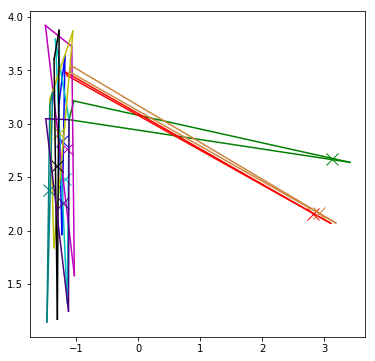

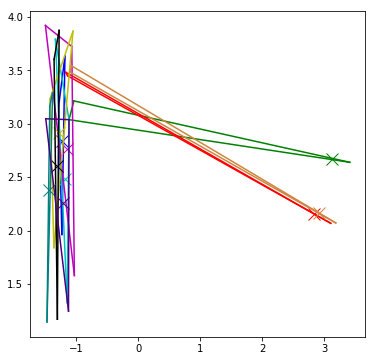

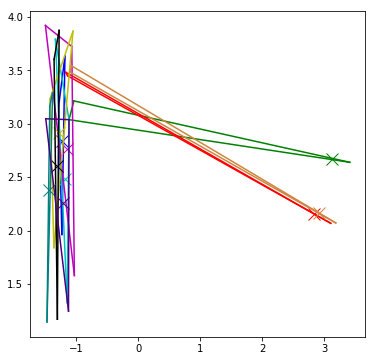

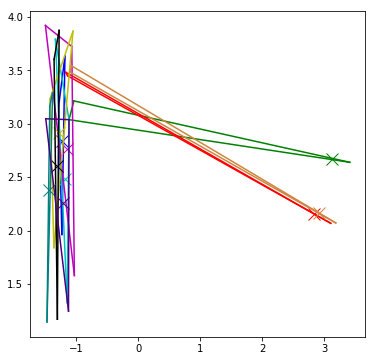

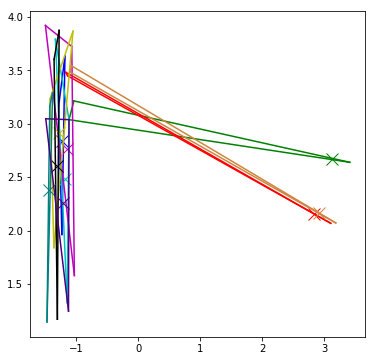

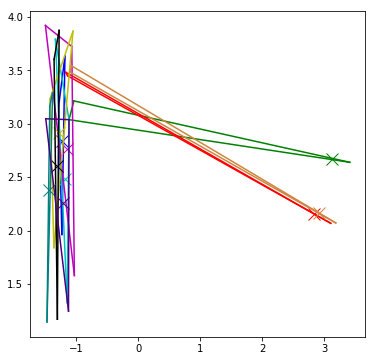

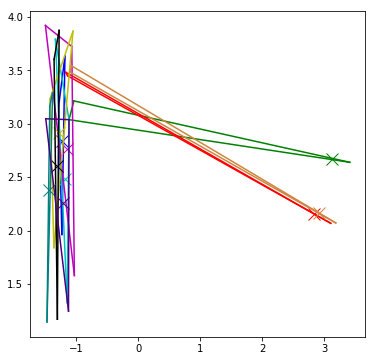

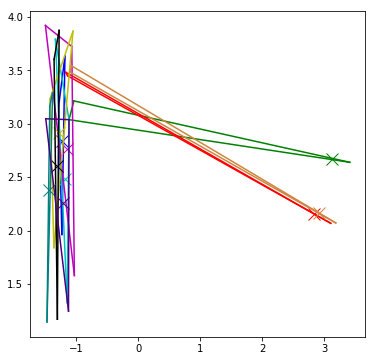

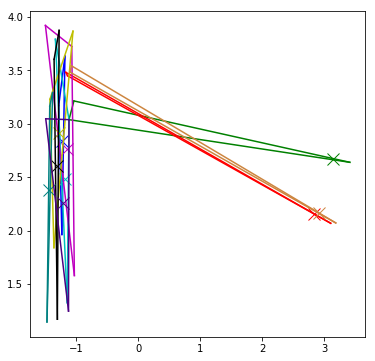

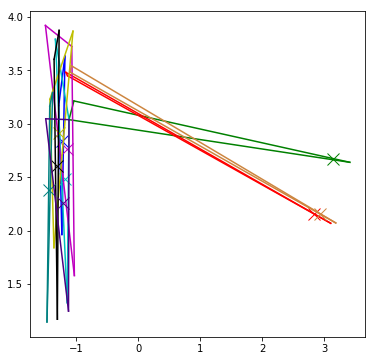

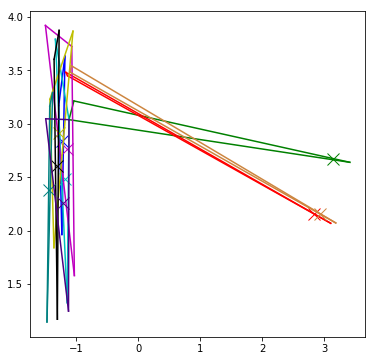

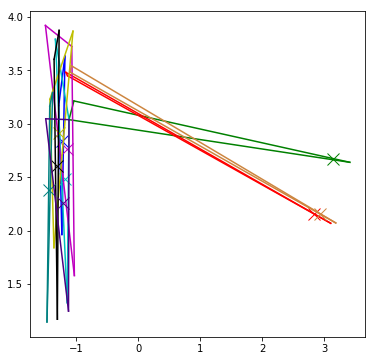

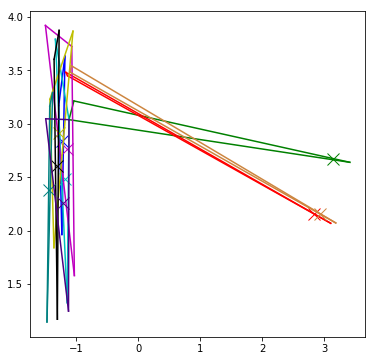

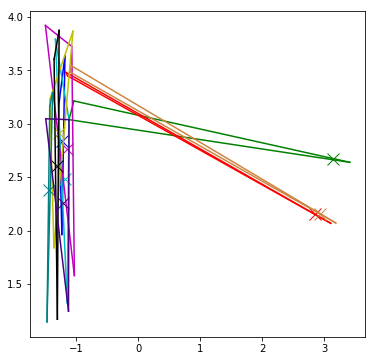

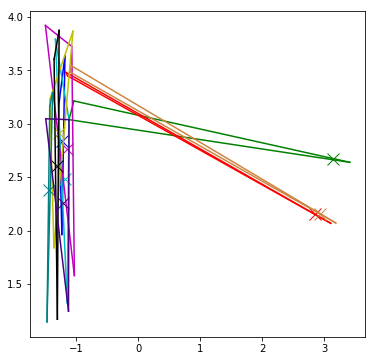

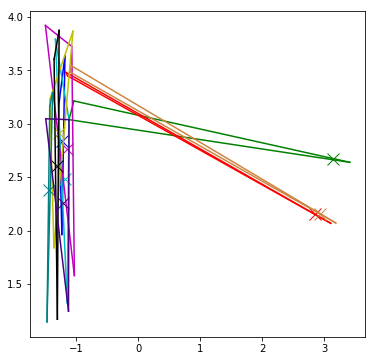

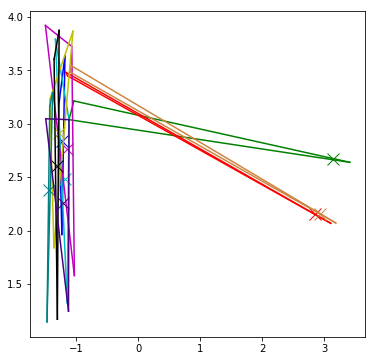

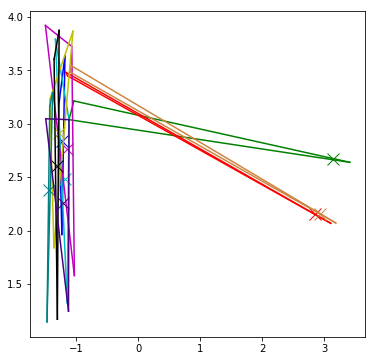

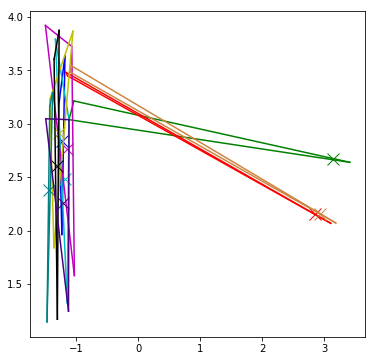

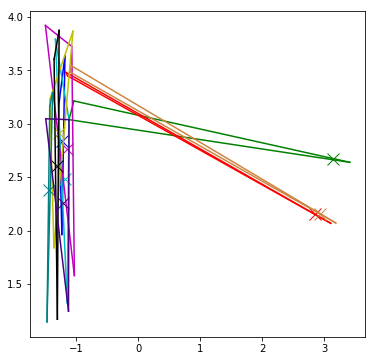

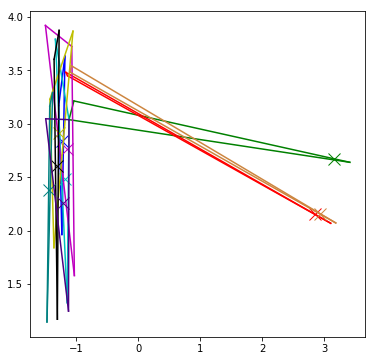

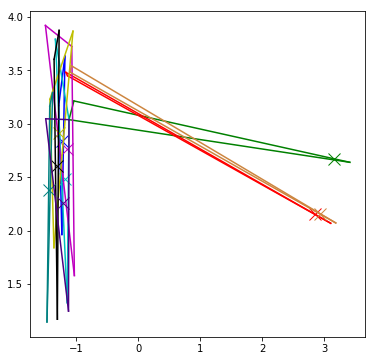

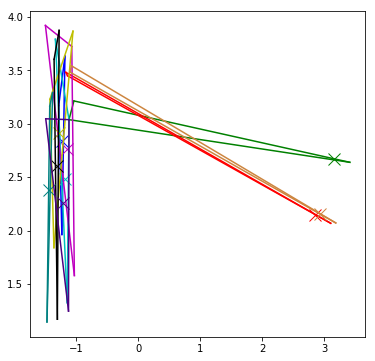

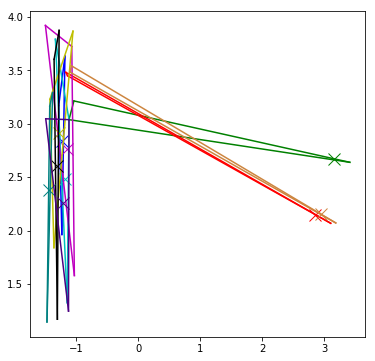

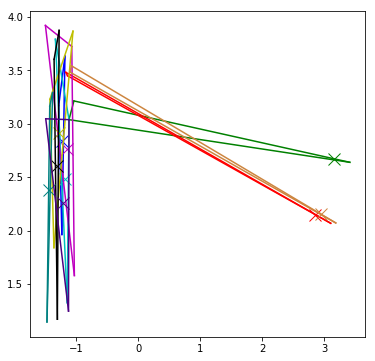

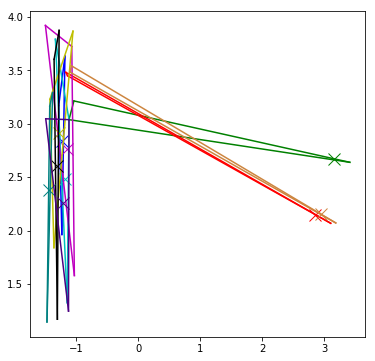

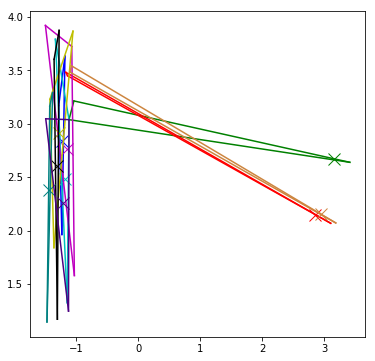

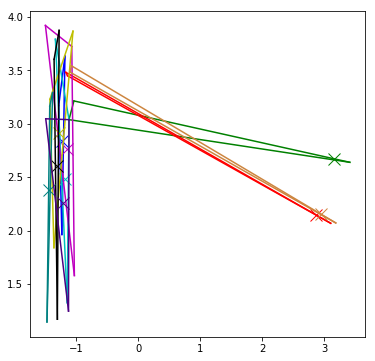

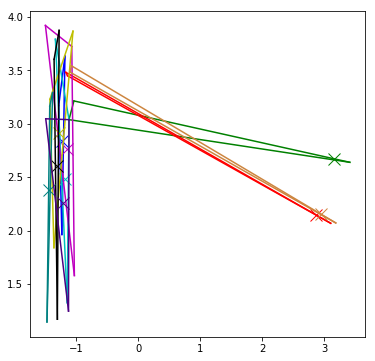

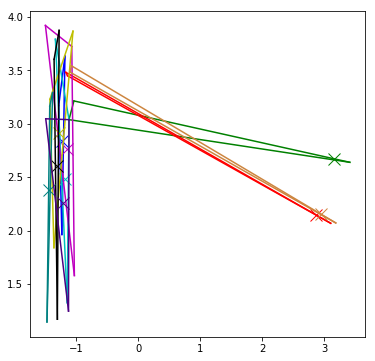

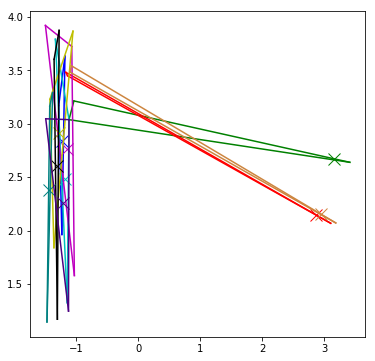

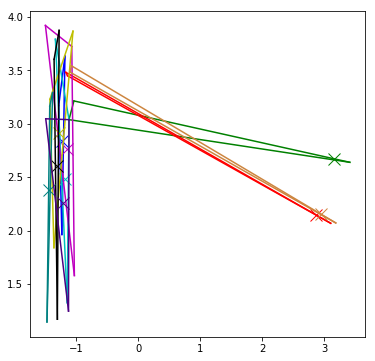

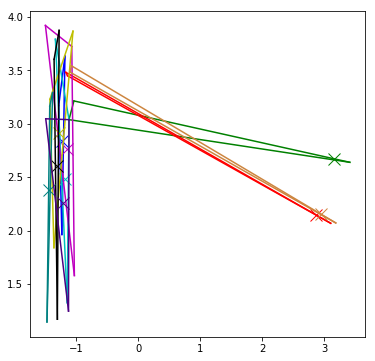

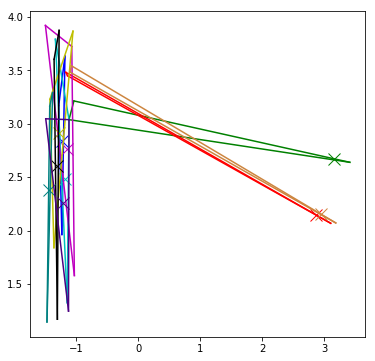

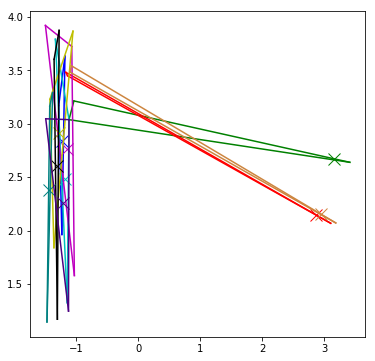

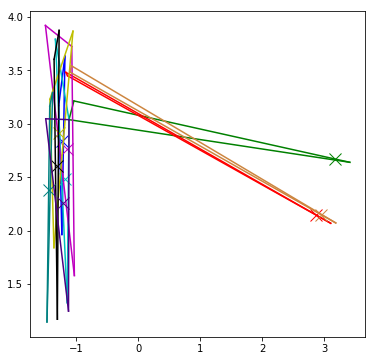

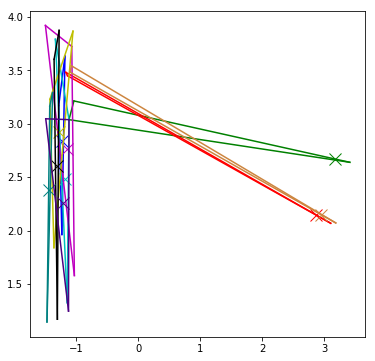

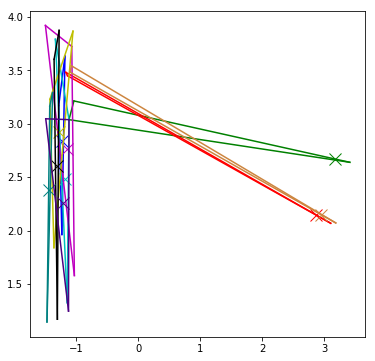

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)




nos_epochs = 100

train_loss=[]

train_acc = [] 
ig = np.random.randint(0,250)
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    avg11_inp = []
    avg11_label = [] 
    running_loss = 0.0
    running_acc = 0
    cnt=0
    c = 0
    iteration = desired_num // batch
    
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        
        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        avg11_inp.append(avg_inp.detach().numpy())
        avg11_label.append(labels.numpy())
        if(c==0):
           
            disp_plot(inputs[:10,:],avg_inp[:10],labels[:10].numpy()
                      ,predicted[:10].numpy(), avg_inp[:10,:], fore_idx[:10].numpy())
            c+=1
            
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        running_acc+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
        
        if cnt % 4 == 3:    # print every 2 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss/4 ))
            print('[%d,%5d] accuracy: %.3f' %(epoch + 1, cnt+1,running_acc/1000))
            
            train_loss.append(running_loss)
            train_acc.append(running_acc /1000)
            running_loss = 0.0
            running_acc = 0
            
            #torch.save(where.state_dict(),"weight_elemental_2/where_model_epoch"+str(epoch)+".pt")
            #torch.save(what.state_dict(),"weight_elemental_2/what_model_epoch"+str(epoch)+".pt")
        cnt=cnt+1
        
print('Finished Training')
#torch.save(where.state_dict(),"weight_elemental_2/where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"weight_elemental_2/what_model_epoch"+str(epoch)+".pt")       
        
        
        

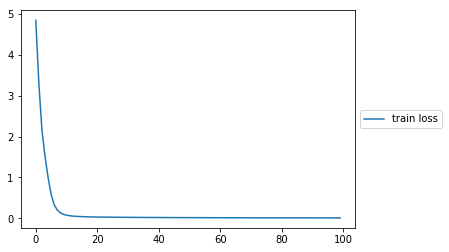

In [25]:
plt.plot(train_loss,label = "train loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

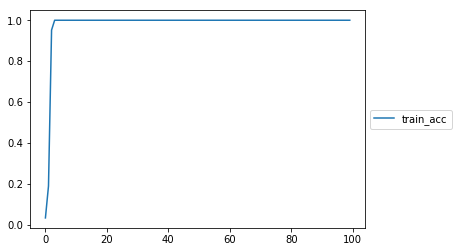

In [26]:
plt.plot(train_acc,label ="train_acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [27]:
dat = np.concatenate(avg11_inp,axis=0)

In [28]:
lbls = np.concatenate(avg11_label,axis=0)

In [29]:
dat[:,0].shape

(1000,)

In [30]:
# plt.scatter(dat[lbls==0,0],dat[lbls==0,1],label = "fg0")
# plt.scatter(dat[lbls==1,0],dat[lbls==1,1],label = "fg1")
# plt.legend()